# Aalborg Airport Taxi Demand — Modeling (Lag-free)

This notebook builds **hour-ahead** models using only features available at time **t** plus the **next-hour schedule/forecast** fields provided by external feeds. **No lag/rolling features are created.**

**Dataset:** `/aalborg_taxi_raw_data.csv`

In [1]:
# --- libraries & setup (no chdir; silences ydata_profiling banner) ---
from pathlib import Path
import warnings, contextlib, io

warnings.filterwarnings("ignore")

# Core libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (9, 4)

# Optional viz libs (only if installed)
try:
    import seaborn as sns
except Exception:
    sns = None
try:
    import plotly.graph_objects as go
    import plotly.express as px
except Exception:
    go = px = None

# ydata_profiling (pandas-profiling) – import without the “Upgrade to ydata-sdk” banner
try:
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        from ydata_profiling import ProfileReport
except Exception:
    ProfileReport = None

## Dataset Preparation
Read the CSV, parse `datetime`, and sort. We also peek at shapes and head.

In [2]:
csv_path = r"C:\Users\mathi\PycharmProjects\PythonProject\data\raw_data\aalborg_taxi_raw_data.csv"
df = pd.read_csv(csv_path, parse_dates=["datetime"]).sort_values("datetime").reset_index(drop=True)
print(df.shape)
df.head(3)

(2000, 20)


,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp_c,feelslike_c,precip_mm,arrivals_landed,arrivals_charter,pax_arrived,taxi_available,taxi_pickups,arrivals_planned_next_h,charter_planned_next_h,wx_forecast_precip_mm_next_h
0,2024-06-01 00:00:00,3,2024,6,0,0,5,0,3,17.497279,16.728547,0.68,6,3,596,27,10,6.0,2.0,0.00
1,2024-06-01 01:00:00,3,2024,6,1,0,5,0,1,13.661669,13.823565,0.00,6,2,636,21,7,5.0,2.0,0.41
2,2024-06-01 02:00:00,3,2024,6,2,0,5,0,3,18.123022,17.869613,0.41,3,3,399,18,8,5.0,2.0,0.00


Let's drop the columns that are not required for further analysis and modeling.

In [5]:
# --- Config (define once) ---
TARGET = "taxi_pickups"
DROP = ["datetime","yr","season","holiday","mnth","weekday","charter_planned_next_h"]

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_metrics(y_true, y_pred, mape_min=1.0):
    """MAE, RMSE, MAPE (%). MAPE only where y_true >= mape_min."""
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mask = y_true >= mape_min
    mape = np.nan if not mask.any() else 100*np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))
    return {"MAE": round(mae,2), "RMSE": round(rmse,2), "MAPE": (None if np.isnan(mape) else round(mape,2))}

def make_design(df, *, horizon=1, extra=None, test_size=0.2):
    """
    Build X,y for t+horizon prediction:
      - drops DROP
      - target = TARGET.shift(-horizon)
      - features = all remaining cols except TARGET (+ extra if given)
      - chronological split (no shuffle)
    """
    d = df.drop(columns=[c for c in DROP if c in df.columns], errors="ignore").copy()
    y = d[TARGET].shift(-horizon)
    feats = [c for c in d.columns if c != TARGET]
    if extra: feats += [c for c in extra if c not in feats]
    X = d[feats]
    mask = y.notna()
    X = X.loc[mask].reset_index(drop=True); y = y.loc[mask].reset_index(drop=True)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, shuffle=False)
    return X_tr, X_te, y_tr, y_te, feats




### Baseline design (no feature engineering)

For the metrics, we will use:
- MAPE
- MAE
- RMSE

In [6]:
# Build design (no extra features)
X_train, X_test, y_train, y_test, FEATURES = make_design(df)
print("Features:", FEATURES)
print("Shapes  :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)




Features: ['hr', 'workingday', 'weathersit', 'temp_c', 'feelslike_c', 'precip_mm', 'arrivals_landed', 'arrivals_charter', 'pax_arrived', 'taxi_available', 'arrivals_planned_next_h', 'wx_forecast_precip_mm_next_h']
Shapes  : (1599, 12) (400, 12) (1599,) (400,)


### Naive (persistence) baseline

In [7]:
# Predict next hour = current hour (within the test window)
y_pred_naive = y_test.shift(1)
y_pred_naive.iloc[0] = y_train.iloc[-1]  # first test point uses last train value
metrics_dummy = compute_metrics(y_test, y_pred_naive)
print("Dummy (persistence):", metrics_dummy)


Dummy (persistence): {'MAE': 5.5, 'RMSE': 6.81, 'MAPE': 60.35}


### Random Forest baseline

CPU times: total: 922 ms
Wall time: 150 ms
RF baseline: {'MAE': 3.8, 'RMSE': 4.72, 'MAPE': 44.04}


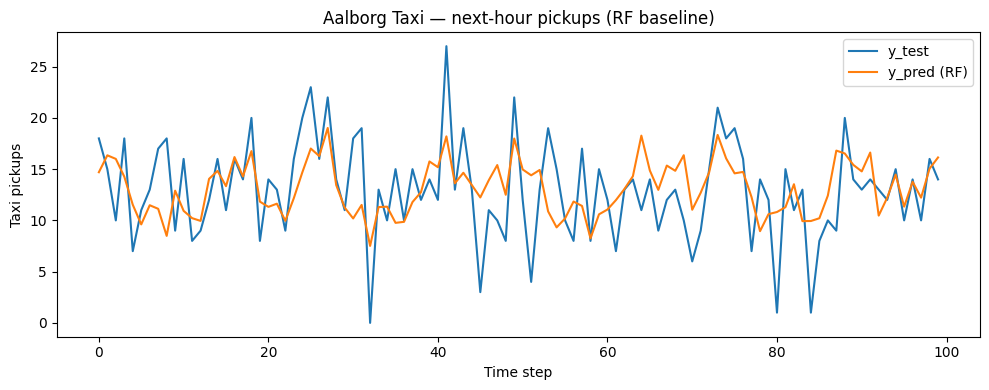

In [8]:
from sklearn.ensemble import RandomForestRegressor as RF

rf = RF(n_estimators=100, random_state=42, n_jobs=-1)
%time rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

metrics_base = compute_metrics(y_test, y_pred_rf)
print("RF baseline:", metrics_base)

# quick plot
n = 100
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:n], label="y_test")
plt.plot(y_pred_rf[:n], label="y_pred (RF)")
plt.title("Aalborg Taxi — next-hour pickups (RF baseline)")
plt.xlabel("Time step"); plt.ylabel("Taxi pickups"); plt.legend(); plt.tight_layout(); plt.show()



### Autocorrelation (to choose lags)

In [9]:
for lag in range(1, 25):
    print(f"Lag {lag}: {df[TARGET].autocorr(lag=lag):.3f}")



Lag 1: 0.136
Lag 2: 0.131
Lag 3: 0.016
Lag 4: 0.009
Lag 5: -0.016
Lag 6: -0.036
Lag 7: -0.054
Lag 8: -0.062
Lag 9: -0.046
Lag 10: -0.017
Lag 11: -0.027
Lag 12: -0.043
Lag 13: -0.060
Lag 14: -0.079
Lag 15: -0.048
Lag 16: -0.082
Lag 17: -0.028
Lag 18: -0.042
Lag 19: 0.026
Lag 20: -0.053
Lag 21: 0.044
Lag 22: 0.077
Lag 23: 0.132
Lag 24: 0.114


### Add target lags (1,2,23,24) and re-run RF

Features (+lags): ['hr', 'workingday', 'weathersit', 'temp_c', 'feelslike_c', 'precip_mm', 'arrivals_landed', 'arrivals_charter', 'pax_arrived', 'taxi_available', 'arrivals_planned_next_h', 'wx_forecast_precip_mm_next_h', 'taxi_pickups_lag_1', 'taxi_pickups_lag_2', 'taxi_pickups_lag_23', 'taxi_pickups_lag_24']
CPU times: total: 406 ms
Wall time: 133 ms
RF + lags: {'MAE': 3.73, 'RMSE': 4.64, 'MAPE': 44.21}
RF baseline (ref): {'MAE': 3.8, 'RMSE': 4.72, 'MAPE': 44.04}


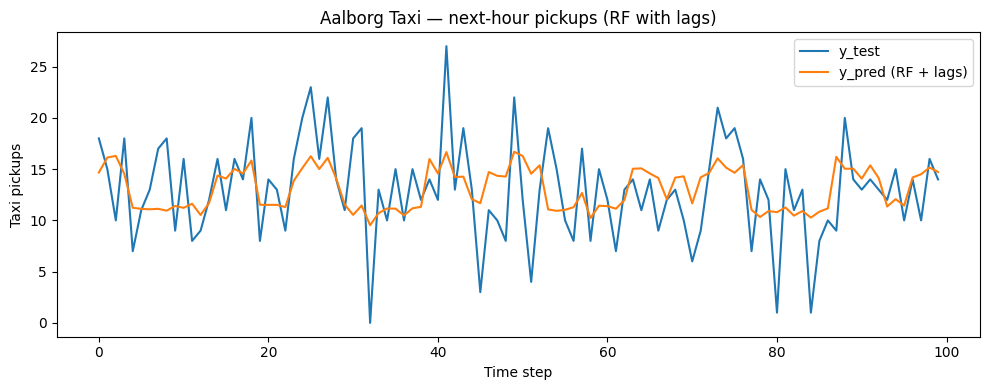

In [10]:
# Create lags on the source df (no filling)
df_lag = df.copy()
for i in [1, 2, 23, 24]:
    df_lag[f"{TARGET}_lag_{i}"] = df_lag[TARGET].shift(i)

extra_feats = [f"{TARGET}_lag_{i}" for i in [1,2,23,24]]
X_train, X_test, y_train, y_test, FEATURES_LAG = make_design(df_lag, extra=extra_feats)
print("Features (+lags):", FEATURES_LAG)

rf_lags = RF(n_estimators=100, random_state=42, n_jobs=-1)
%time rf_lags.fit(X_train, y_train)
y_pred_lags = rf_lags.predict(X_test)

metrics_lags = compute_metrics(y_test, y_pred_lags)
print("RF + lags:", metrics_lags)
print("RF baseline (ref):", metrics_base)

# quick plot
n = 100
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:n], label="y_test")
plt.plot(y_pred_lags[:n], label="y_pred (RF + lags)")
plt.title("Aalborg Taxi — next-hour pickups (RF with lags)")
plt.xlabel("Time step"); plt.ylabel("Taxi pickups"); plt.legend(); plt.tight_layout(); plt.show()



### Quick interpretation

Dummy → just predicts next hour = current hour. Weak baseline but still a reference.

RF baseline → clearly better than dummy: ~30% lower MAE/RMSE.

Adding lags → small but consistent improvement in MAE & RMSE.
MAPE is almost the same — that’s normal when counts are small/noisy.

### Next step suggestions

Lags alone don’t add much — maybe the taxi demand isn’t strongly autocorrelated beyond what features already capture.

Try feature engineering beyond lags:

RRolling averages of past demand (taxi_pickups)

Weather trend features (hour-over-hour deltas)

Try a different regressor: LightGBM or XGBoost might handle the mixed numeric + categorical features better.

In [11]:
# --- Imports & config ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

TARGET = "taxi_pickups"
DROP = ["datetime","yr","season","holiday","mnth","weekday","charter_planned_next_h"]

def compute_metrics(y_true, y_pred, mape_min=1.0):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mask = y_true >= mape_min
    mape = np.nan if not mask.any() else 100*np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))
    return {"MAE": round(mae,2), "RMSE": round(rmse,2), "MAPE": (None if np.isnan(mape) else round(mape,2))}





In [12]:
# --- Simple FE: rolling averages of past demand + weather trends ---
df_fe = df.drop(columns=[c for c in DROP if c in df.columns], errors="ignore").copy()

# Target (t+1)
df_fe["target"] = df_fe[TARGET].shift(-1)

# Rolling past demand (use only history: shift(1) before rolling)
df_fe["pickups_roll3"] = df_fe[TARGET].shift(1).rolling(3).mean()
df_fe["pickups_roll6"] = df_fe[TARGET].shift(1).rolling(6).mean()

# Weather trend features (current minus previous hour)
df_fe["d_temp_c"]      = df_fe["temp_c"]      - df_fe["temp_c"].shift(1)
df_fe["d_feelslike_c"] = df_fe["feelslike_c"] - df_fe["feelslike_c"].shift(1)
df_fe["d_precip_mm"]   = df_fe["precip_mm"]   - df_fe["precip_mm"].shift(1)

# (Optional) hour cycle helps many models
df_fe["hr_sin"] = np.sin(2*np.pi*df_fe["hr"]/24)
df_fe["hr_cos"] = np.cos(2*np.pi*df_fe["hr"]/24)

# Drop rows with NaNs created by shift/rolling/target
need_cols = ["target","pickups_roll3","pickups_roll6","d_temp_c","d_feelslike_c","d_precip_mm"]
df_fe = df_fe.dropna(subset=need_cols).reset_index(drop=True)



In [13]:
# --- Build X / y ---
feature_cols = [c for c in df_fe.columns if c not in [TARGET, "target"]]
X = df_fe[feature_cols]
y = df_fe["target"]

# Chronological split (no shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("n_features:", len(feature_cols))
print("Train/Test:", X_train.shape, X_test.shape)



n_features: 19
Train/Test: (1594, 19) (399, 19)


In [14]:
# --- Gradient Boosting with small grid & TimeSeriesSplit ---
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3],
    "min_samples_leaf": [3, 5],
    "subsample": [0.8, 1.0],
    "max_features": ["sqrt", None],
}

tscv = TimeSeriesSplit(n_splits=5)
search = GridSearchCV(
    gbr, param_grid, scoring="neg_mean_absolute_error",
    cv=tscv, n_jobs=-1, verbose=0
)
%time search.fit(X_train, y_train)

best_gbr = search.best_estimator_
print("Best params:", search.best_params_)
y_pred = best_gbr.predict(X_test)
metrics_gbr = compute_metrics(y_test, y_pred)
metrics_gbr




CPU times: total: 1.02 s
Wall time: 15.9 s
Best params: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 200, 'subsample': 0.8}


{'MAE': 3.69, 'RMSE': 4.62, 'MAPE': 43.97}

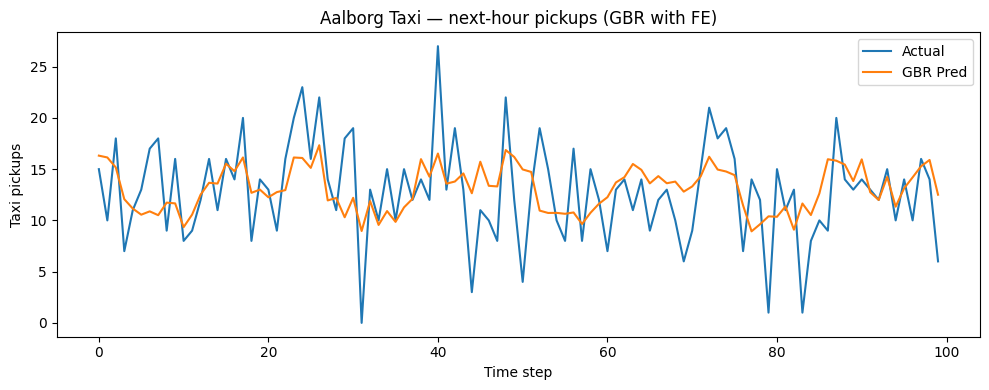

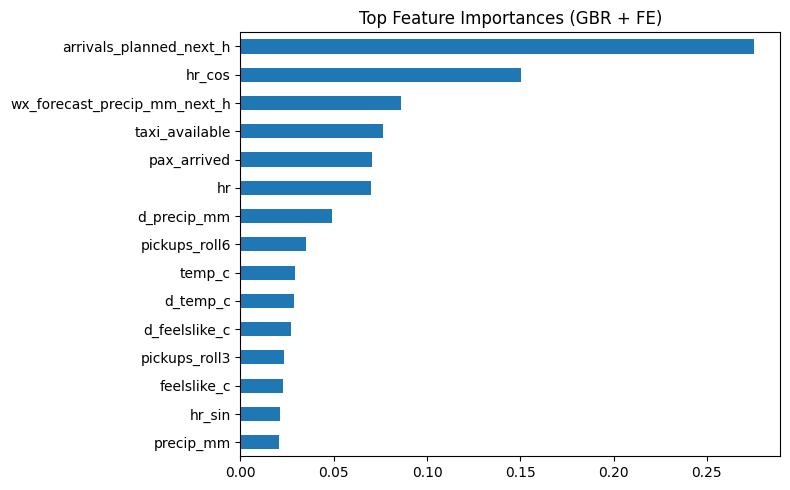

In [15]:
# --- Prediction vs actual (first n points) ---
n = 100
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:n], label="Actual")
plt.plot(y_pred[:n], label="GBR Pred")
plt.title("Aalborg Taxi — next-hour pickups (GBR with FE)")
plt.xlabel("Time step"); plt.ylabel("Taxi pickups")
plt.legend(); plt.tight_layout(); plt.show()

# --- Top feature importances ---
imp = pd.Series(best_gbr.feature_importances_, index=feature_cols).sort_values(ascending=False)[:15]
plt.figure(figsize=(8,5))
imp.plot(kind="barh"); plt.gca().invert_yaxis()
plt.title("Top Feature Importances (GBR + FE)")
plt.tight_layout(); plt.show()



Dummy: MAE 5.50 / RMSE 6.81 / MAPE 60.35

RF baseline: MAE 3.80 / RMSE 4.72 / MAPE 44.04

RF + lags: MAE 3.73 / RMSE 4.64 / MAPE 44.21

GBR (tuned): MAE 3.69 / RMSE 4.62 / MAPE 43.97


